Para o método ∈-restrito nós tornamos uma função objetivo em restrição, para nosso problema optaremos inicialmente pela segunda função objetivo.  
Ao utilizarmos métodos de otimização mono-objetivo vemos que a nossa segunda função objetivo foi mais difícil de ser otimizada, por conta disso utilizaremos ela como função objetivo e a função F1 se tornará restrição.

In [1]:
import pandas as pd
import numpy as np
import json
import random

from tqdm import tqdm

Arquivo csv adaptado para diminuir trabalho com tratamento de dados

In [2]:
url = "https://raw.githubusercontent.com/LucasAzvd/teoria-da-decis-o/main/data/i5x25.csv?token=AI4MMZ5LFVT2YERE7VVKHHLBXKDD6"
df = pd.read_csv(url)
df.head(2)

,tarefa,maq_1,maq_2,maq_3,maq_4,maq_5,peso,due_date
0,1,2,1,4,7,8,8,6
1,2,8,3,2,1,5,5,6


# Funções objetivo

## Min F1(x)

\begin{equation}
minf_{1}(x)= C_{max} = max\left (\sum_{j=1}^{N}\sum_{k=1}^{N} t_{ij}x_{ijk}  \right )\\
i\epsilon\left\{ i,...,M \right \}
\end{equation}

Essa função nos trás o tempo de execução máximo de uma máquina, somando todas as tarefas que foram executadas na mesma.   
Seu retorno é representado pelo maior tempo de execução das máquinas e sua minimização 

In [3]:
def min_f1_restricao(df_alocacao: pd.DataFrame, epsilon: int) -> dict:
    """Minimizar o makespan, calculando o tempo de execução em todas as máquinas 
            e retornando a que mais demora
    Args
        df_alocacao[pd.DataFrame]: Dataframe com a alocação das máquinas
        epsilon[int]: Valor do ∈-restrito no nosso código
    Returns:
        int : O maior tempo de execução das máquinas
    """

    tempo_maximo_atual = max(df_alocacao.iloc[:, 1:6].sum())
    if tempo_maximo_atual > epsilon: # True para restricao violada
        return True
    return False

## Min F2(x)

\begin{equation}
minf_{2}(x)= \sum_{j=1}^{N} w_{j}t_{j}
\end{equation}

Se refere a soma ponderada dos atrasos que ocorreram com a penalidade $W_{j}$.

In [4]:
def min_f2(df_alocacao):
    df_alocacao['penalidade'] = df_alocacao.iloc[:, 1:6].max(axis=1)
    df_alocacao['penalidade'] = df_alocacao['penalidade'] - df_alocacao['due_date']
    df_alocacao.loc[df_alocacao['penalidade'] < 0, 'penalidade'] = 0
    df_alocacao['penalidade'] = df_alocacao['penalidade']*df_alocacao['peso']

    penalidade = max(df_alocacao.drop(['tarefa', 'peso', 'due_date'], axis=1).sum())

    return penalidade

## Restrições

Iremos implementar as seguintes restrições na função abaixo:  
`restricao_tarefas_maquinas`
\begin{equation}
 \sum_{i=1}^{M}\sum_{k=1}^{N+1} x_{ijk} = 1,\forall j\epsilon \left \{ 1,...,N \right \}
\end{equation}

`restricao_tempo_máximo`
\begin{equation}
C_{max}\geq  \sum_{i=1}^{M}\sum_{k=1}^{N+1} t_{ij}x_{ijk},\forall i\epsilon \left \{ 1,...,M \right \}
\end{equation}

Restrição redundante para o nosso código. Se trata de validar que um máquina pode ficar sem nenhuma tarefa atribuída.
\begin{equation}
\sum_{k=1}^{N} x_{i0k}\leq 1,\forall i\epsilon \left \{ 1,...,M \right \}
\end{equation}

Restrição redundante para o nosso código. Se trata de verificação de finalização de tarefas antes da atribuição a uma máquina.
\begin{equation}
\sum_{j=1,j\neq h}^{N+1} x_{ijh} - \sum_{k=1,k\neq h}^{N+1} x_{ihk} = 0,\forall h\epsilon \left \{ 1,...,N \right \}e\forall i\epsilon \left \{ 1,...,M \right \}
\end{equation}

Restrição redundante para o nosso código. Se trata se a tarefa está exutando uma tarefa ou não.
\begin{equation}
C_{ik}\geqslant C_{ij} - L + \left ( t_{ij}+L \right )x_{ijk},\forall \text{j e k}\epsilon \left \{ 1,..,N \right \}
\end{equation}

`restricao_tempo_atraso`
\begin{equation}
T_{j}\geq C_{j}-d,\forall j\epsilon \left \{ 1,...,N \right \}
\end{equation}

Caso alguma restrição seja violada, retornamos **True**.

In [5]:
def restricao_tarefas_maquinas(df_alocacao: pd.DataFrame):
    """Cada tarefa deverá ir para uma máquina obrigatoriamente, garantindo que todas as tarefas sejam executadas.
    Nela verificamos de existe alguma linha vazia no nosso dataframe de linhas de execução, que representaria uma tarefa sem alocar.
    Também verificamos se as tarefas são alocadas apenas para uma máquina.
    """
    soma_linhas_dataframe = df_alocacao.iloc[:, 1:6].nunique(axis=1)
    for i in soma_linhas_dataframe:
        if i != 2:  # Restricao violada
            # print("Restrito: restricao_tarefas_maquinas")
            return True

    return False

In [6]:
def restricao_tempo_maximo(df_alocacao: int, tempo_execucao_maquinas: list):
    """Nesta restrição garantimos que o tempo máximo de execução seja respeitado.
    """
    for tempo_exec in np.array(df_alocacao.iloc[:,1:6].sum()):
        if tempo_exec > tempo_execucao_maquinas: # Viola restrição
            # print("Restrito: restricao_tempo_maximo")
            return True
        else:
            return False

In [7]:
def restricao_tempo_atraso(df_alocacao: True):
    """Restrição referente ao tempo de atraso, ela delimita que o tempo de execução
    da tarefa tem que ser limitado pelo tempo d definido."""
    df_aux = df_alocacao.copy()
    df_aux['tempo_atraso'] = df_aux['due_date'] - df_alocacao.iloc[:, 1:6].max(axis=1)
    
    df_aux['restricao_atraso'] = df_aux['tempo_atraso'] - df_aux['due_date'] + df_alocacao.iloc[:, 1:6].max(axis=1)
    if sum(df_aux['restricao_atraso']):
        # print("Restrito: restricao_tempo_atraso")
        return True
    else:
        return False

## Estrutura de vizinhança

1.   Shift
2.   Swtich
3.   Swap
4.   Two-Shift
5.   Task-Move


In [8]:
def swap(df_alocacao: pd.DataFrame, df: pd.DataFrame):
    quant_tarefas = 25
    quant_maquinas = 5
    tarefa_swap_1 = random.randint(1, quant_tarefas)
    if tarefa_swap_1 == quant_tarefas:
        tarefa_swap_2 = tarefa_swap_1 - 1
    else:
        tarefa_swap_2 = tarefa_swap_1 + 1

    tarefa_swap_1_list = df_alocacao[df_alocacao['tarefa']
                                     == tarefa_swap_1].iloc[:, 1:6].values[0].copy()
    tarefa_swap_2_list = df_alocacao[df_alocacao['tarefa']
                                     == tarefa_swap_2].iloc[:, 1:6].values[0].copy()
    for i in range(0, len(tarefa_swap_1_list)):
        if tarefa_swap_1_list[i] > 0:
            maq_1 = i+1
            df_alocacao.loc[df_alocacao["tarefa"]
                            == tarefa_swap_1, f'maq_{i+1}'] = 0

    for i in range(0, len(tarefa_swap_2_list)):
        if tarefa_swap_2_list[i] > 0:
            maq_2 = i+1
            df_alocacao.loc[df_alocacao["tarefa"] ==
                            tarefa_swap_2, f'maq_{maq_2}'] = 0

    df_alocacao.loc[df_alocacao["tarefa"] == tarefa_swap_1,
                    f'maq_{maq_2}'] = df[df["tarefa"] == tarefa_swap_1][f'maq_{maq_2}']
    df_alocacao.loc[df_alocacao["tarefa"] == tarefa_swap_2,
                    f'maq_{maq_1}'] = df[df["tarefa"] == tarefa_swap_2][f'maq_{maq_1}']

    return df_alocacao

In [9]:
def task_move(df_alocacao: pd.DataFrame, df: pd.DataFrame):
    quant_tarefas = 25
    task_to_move = random.randint(1, quant_tarefas)

    list_tasks = df_alocacao[df_alocacao['tarefa'] ==
                             task_to_move].iloc[:, 1:6].values[0].copy()
    for i in range(0, len(list_tasks)):
        if list_tasks[i] > 0:
            maq = i+1
            df_alocacao.loc[df_alocacao["tarefa"]
                            == task_to_move, f'maq_{maq}'] = 0
            if maq == 5:
                df_alocacao.loc[df_alocacao["tarefa"] == task_to_move,
                                f'maq_{maq-1}'] = df[df['tarefa'] == task_to_move][f'maq_{maq-1}']
            else:
                df_alocacao.loc[df_alocacao["tarefa"] == task_to_move,
                                f'maq_{maq+1}'] = df[df['tarefa'] == task_to_move][f'maq_{maq+1}']
            break

    return df_alocacao

In [10]:
def estruturas(df_alocacao, df, k):
    if k==1:
        df_alocacao_new = swap(df_alocacao, df)
    else:
        df_alocacao_new = task_move(df_alocacao, df)
    return df_alocacao_new

## Variáveis

In [11]:
quant_maq = 5
quant_tarefas = df.shape[0]

Alocando as tarefas nas máquinas aleatóriamente

In [12]:
def aloca_tarefas(df_alocacao, quant_tarefas):
    for i in range(0, quant_tarefas):
        maq_aloc = random.randint(1,quant_maq)
        while (df_alocacao[f'maq_{maq_aloc}'].nunique()-1)  == 5:
            maq_aloc = random.randint(1,quant_maq)

        # Pegando tarefa i e atribuindo o valor dela a maquina referente
        df_alocacao.iloc[i][f'maq_{maq_aloc}'] = df[df['tarefa'] == i+1][f'maq_{maq_aloc}'].values[0]
    return df_alocacao


Calculando a penalidade inicial da nossa alocação

In [13]:
def calcula_penalidade(df_alocacao):
    df_alocacao['penalidade'] = 0
    df_alocacao['penalidade'] = df_alocacao.iloc[:, 1:6].max(axis=1)
    df_alocacao['penalidade'] = df_alocacao['penalidade'] - df_alocacao['due_date']
    df_alocacao.loc[df_alocacao['penalidade'] < 0, 'penalidade'] = 0
    df_alocacao['penalidade'] = df_alocacao['penalidade']*df_alocacao['peso']
    return df_alocacao

In [14]:
def gera_alocacao():
    """Gera alocação para as máquinas aleatoriamente"""
    df_alocacao = df.copy()
    df_alocacao['maq_1'] = 0
    df_alocacao['maq_2'] = 0
    df_alocacao['maq_3'] = 0
    df_alocacao['maq_4'] = 0
    df_alocacao['maq_5'] = 0
    df_alocacao = aloca_tarefas(df_alocacao, quant_tarefas)
    df_alocacao = calcula_penalidade(df_alocacao)
    return df_alocacao

## 1.6 Soma Ponderada

Para aplicação da função de soma ponderada iremos realizar chamadas dos dois modelos de otimização simultaneamente, nisso aplicaremos um peso em cada e gerar o novo resultado. Nosso primeiro peso será 0.5(igual para amas funções) após ele iremos escolher aleatóriamente o valor dos pesos.

In [15]:
def epsilon_restrito(peso_1, peso_2, df_alocacao):
    resultado = 0
    tempo_maximo_execucao = min_f1(df_alocacao)
    penalidade_maximo_execucao = min_f2(df_alocacao)
    
    tempo_maximo_execucao = tempo_maximo_execucao*peso_1
    penalidade_maximo_execucao = penalidade_maximo_execucao*peso_2
    
    return tempo_maximo_execucao, penalidade_maximo_execucao

# Execução do nosso algoritmo

In [18]:
def exec_algo(n_execucoes, n_epocas, epsilon, dict_results):

    for n_exec in range(0, n_execucoes):
        df_alocacao = gera_alocacao()
        penalidade_maximo = max(df_alocacao.drop(['tarefa', 'peso', 'due_date'], axis=1).sum())

        list_penalidades = []
        list_penalidades.append(penalidade_maximo)

        k = 1
        for epc in tqdm(range(0, n_epocas)):
        # for epc in range(0, n_epocas):
            penalidade_maximo_execucao = penalidade_maximo

            df_alocacao_new = df_alocacao.copy()
            df_alocacao_new = estruturas(df_alocacao, df, k)
            k=1
            restricao_1 = restricao_tarefas_maquinas(df_alocacao_new)
            restricao_2 = restricao_tempo_maximo(df_alocacao_new, penalidade_maximo_execucao)
            restricao_3 = restricao_tempo_atraso(df_alocacao_new)
            restricao_f1 = min_f1_restricao(df_alocacao_new, epsilon)
            if restricao_1 or restricao_2 or restricao_3 or restricao_f1:
                # Se alguma restrição verdadeira, adicionamos os valores antigos a lista
                list_penalidades.append(penalidade_maximo)
                k=0 # Troca do método

            else:
                penalidade_maximo_execucao = min_f2(df_alocacao_new)

                if penalidade_maximo_execucao < penalidade_maximo:
                    penalidade_maximo = penalidade_maximo_execucao
                    df_alocacao = df_alocacao_new.copy()

                list_penalidades.append(penalidade_maximo)
        dict_results[f"epsilon_{epsilon}"] = list_penalidades

    return dict_results
    

Os valores para epsilon foram extraídos da execução do algoritmo no TC 02, sendo do maior valor (restrição mais fraca, até o melhor ótimo)

In [24]:
n_epocas = 100
n_execucoes = 1
execucoes_dict = {}
list_epsilon = [100, 80, 60, 40, 20] 
for epsilon in list_epsilon:
    execucoes_dict = exec_algo(n_execucoes, n_epocas, epsilon, execucoes_dict)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.43it/s]


In [25]:
print("Para execução de f2 temos o seguinte resultado:")
for i in execucoes_dict.keys():
    media = np.mean(execucoes_dict[i])
    std = np.std(execucoes_dict[i])
    max_value = np.max(execucoes_dict[i])
    print(f"Para a execução {i} temos média:{round(media, 2)}, desvio padrão:{round(std, 2)} e valor máximo:{max_value}")

Para execução de f2 temos o seguinte resultado:
Para a execução epsilon_100 temos média:143.34, desvio padrão:28.26 e valor máximo:234
Para a execução epsilon_80 temos média:47.77, desvio padrão:19.91 e valor máximo:153
Para a execução epsilon_60 temos média:82.91, desvio padrão:30.52 e valor máximo:156
Para a execução epsilon_40 temos média:98.0, desvio padrão:42.99 e valor máximo:175
Para a execução epsilon_20 temos média:77.0, desvio padrão:0.0 e valor máximo:77


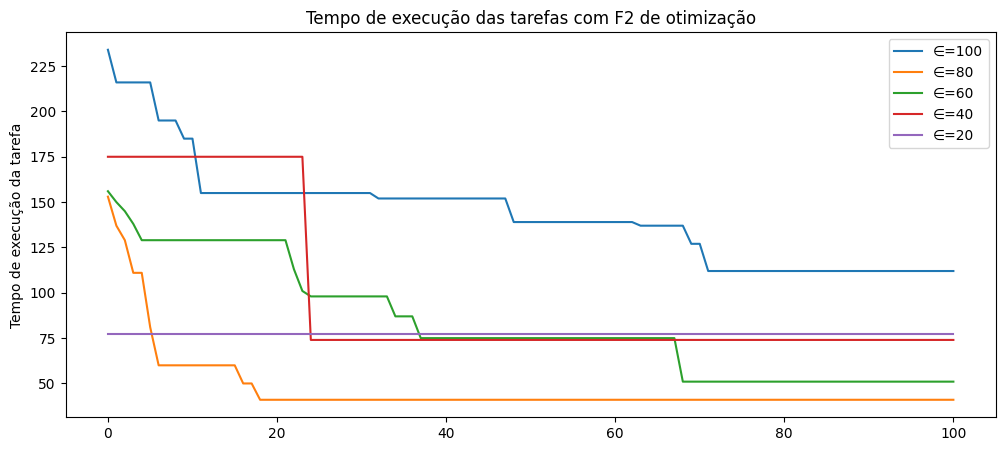

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(execucoes_dict['epsilon_100'], label='∈=100')
plt.plot(execucoes_dict['epsilon_80'], label='∈=80')
plt.plot(execucoes_dict['epsilon_60'], label='∈=60')
plt.plot(execucoes_dict['epsilon_40'], label='∈=40')
plt.plot(execucoes_dict['epsilon_20'], label='∈=20')

plt.title("Tempo de execução das tarefas com F2 de otimização")
plt.ylabel("Tempo de execução da tarefa")
plt.legend()
plt.show()